Momentum is useful for optimizing machine learning models because it can improve the speed, stability, and accuracy of gradient descent. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights
import time
from torchvision import datasets 

In [2]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12455'

    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()
    
class LungColonCancerDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super(LungColonCancerDataset, self).__init__(root=root_dir, transform=transform)
        
def plot_learning_curves(train_losses, valid_losses, valid_accuracies):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.show()

In [3]:
train_losses = []
valid_losses = []
valid_accuracies = []
epoch_times = []  # List to store epoch durations

In [4]:
def train(rank, world_size, batch_size):
    
    setup(rank, world_size)

    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    data_dir = '/home/hindupur.v/varsha_hpp/dataset/lung_colon_image_set'
    
    # Dataset setup
    train_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'train'), transform=transform)
    train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of training images (Rank {rank}): {len(train_dataset)}\n")

    validation_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'valid'), transform=transform)
    validation_sampler = DistributedSampler(validation_dataset, num_replicas=world_size, rank=rank)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, sampler=validation_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of validation images (Rank {rank}): {len(validation_dataset)}\n")

    test_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'test'), transform=transform)
    test_sampler = DistributedSampler(test_dataset, num_replicas=world_size, rank=rank)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of test images (Rank {rank}): {len(test_dataset)}\n")

    # Initialize the model
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    num_ftrs = model.fc.in_features
    num_classes = 5
    model.fc = nn.Linear(num_ftrs, num_classes)  # 5 classes
    
    # Wrap the model with DistributedDataParallel
    ddp_model = nn.parallel.DistributedDataParallel(model)
    print(f"[Rank {rank}] Model initialized and wrapped in DDP.\n")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001, momentum=0.9)
    
    print(f"[Rank {rank}] Optimizer and loss function are set up.\n")

    num_epochs = 10
    
    start_time = time.time()  # Start timing
    print("start_time", start_time)

    for epoch in range(num_epochs):
        ddp_model.train() 
        epoch_start_time = time.time()  # Start time for the epoch
        running_loss = 0.0
        epoch_train_losses = []
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = ddp_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_idx % 10 == 0:  # Log every 10 batches
                print(f"[Rank {rank}] Epoch {epoch+1} Batch {batch_idx+1}: Loss {loss.item()}\n")

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        print(f'[Rank {rank}] Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}\n')
        
        epoch_duration = time.time() - epoch_start_time  # Calculate duration of the epoch
        epoch_times.append(epoch_duration)  # Append epoch duration to the list
        print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds\n")

        ddp_model.eval()  # Setting model to evaluate mode
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = ddp_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(validation_loader)
        epoch_accuracy = correct.double() / len(validation_dataset)

        valid_losses.append(epoch_val_loss)
        valid_accuracies.append(epoch_accuracy)

        print(f'[Rank {rank}] Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_accuracy:.4f}\n')

        
    # Plot learning curves
    plot_learning_curves(train_losses, valid_losses, valid_accuracies)
    
    cleanup()
    
    end_time = time.time()  # End timing
    print("total end_time", end_time)
    
    duration = end_time - start_time
    print(f"Rank {rank}: Training duration: {duration:.2f} seconds")
    
    # saving the model for later use without disturbing the rest of the code
    torch.save(model.state_dict(), 'lung_colon_cancer_model_on_20_CPU.pth')

    return ddp_model, train_losses, valid_losses, valid_accuracies, epoch_times

Number of training images (Rank 3): 20000

Number of training images (Rank 4): 20000

Number of training images (Rank 8): 20000
Number of training images (Rank 5): 20000
Number of training images (Rank 7): 20000
Number of training images (Rank 0): 20000



Number of validation images (Rank 3): 2500

Number of training images (Rank 6): 20000

Number of validation images (Rank 4): 2500
Number of training images (Rank 2): 20000
Number of training images (Rank 9): 20000




Number of training images (Rank 1): 20000
Number of validation images (Rank 8): 2500


Number of validation images (Rank 0): 2500

Number of validation images (Rank 7): 2500

Number of validation images (Rank 5): 2500
Number of validation images (Rank 9): 2500
Number of validation images (Rank 2): 2500

Number of validation images (Rank 6): 2500
Number of validation images (Rank 1): 2500

Number of test images (Rank 3): 2500


Number of test images (Rank 8): 2500


Number of test images (Rank 4): 2500
Number of test ima

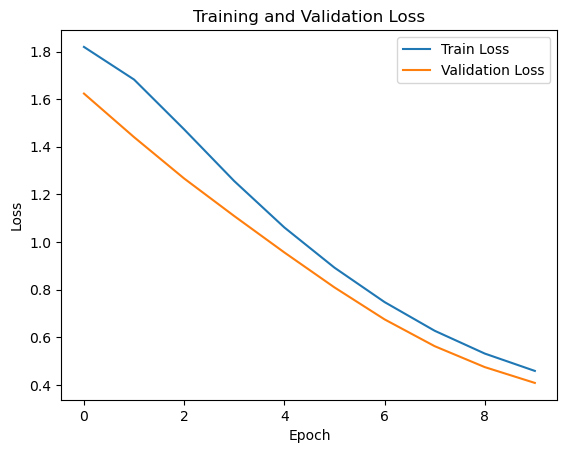

[Rank 8] Epoch 10/10, Val Loss: 0.4092, Accuracy: 0.0904



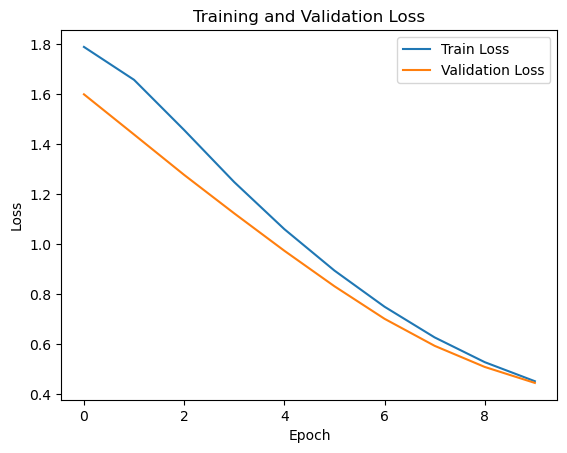

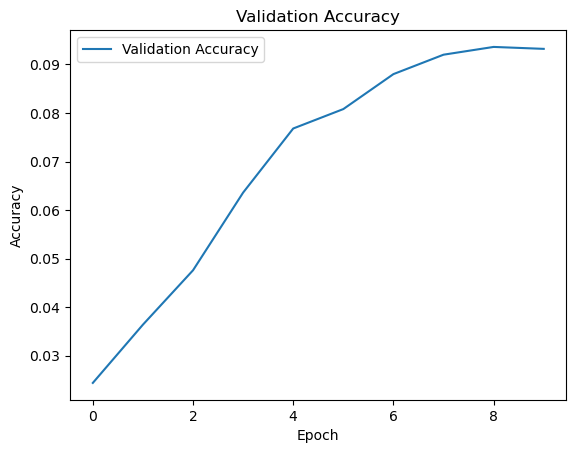

total end_time 1713050009.1708276
Rank 1: Training duration: 2485.12 seconds


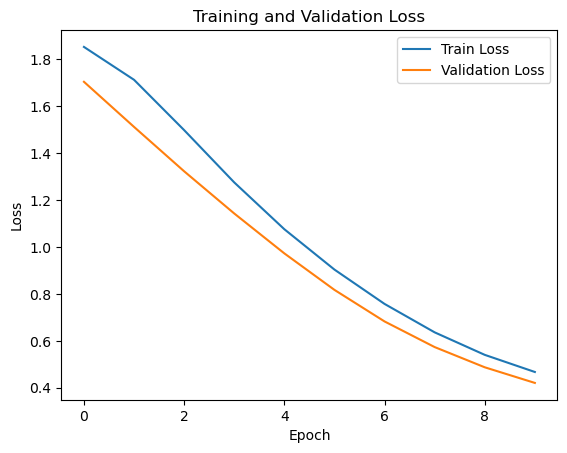

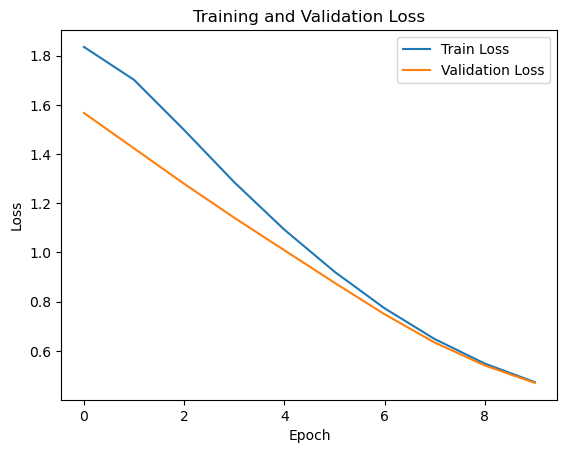

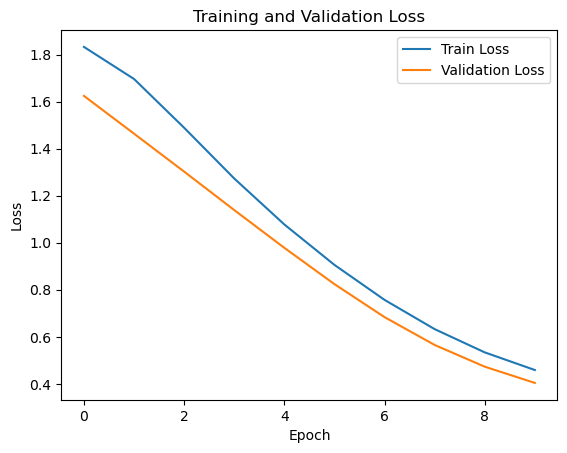

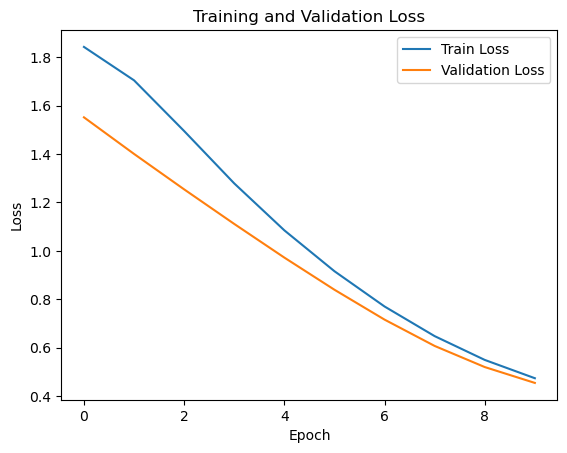

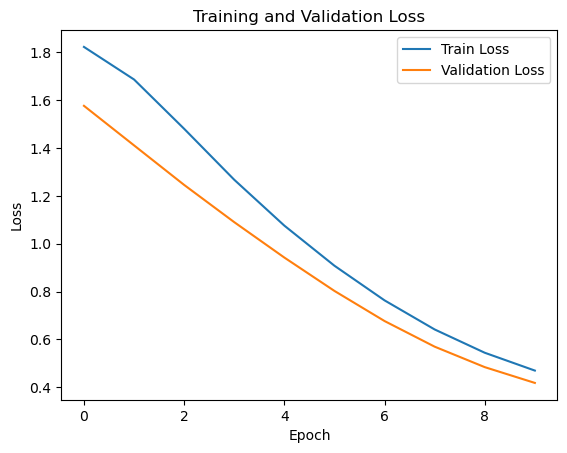

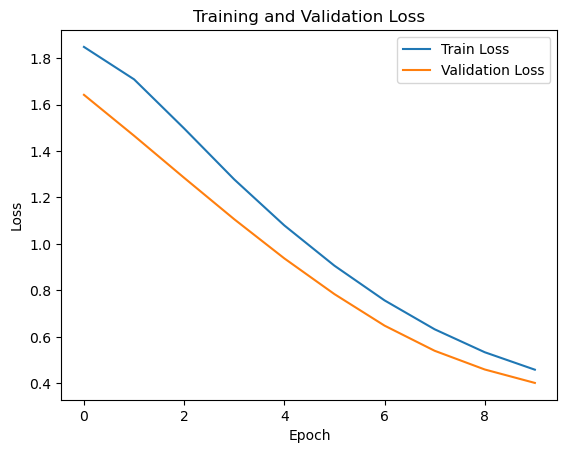

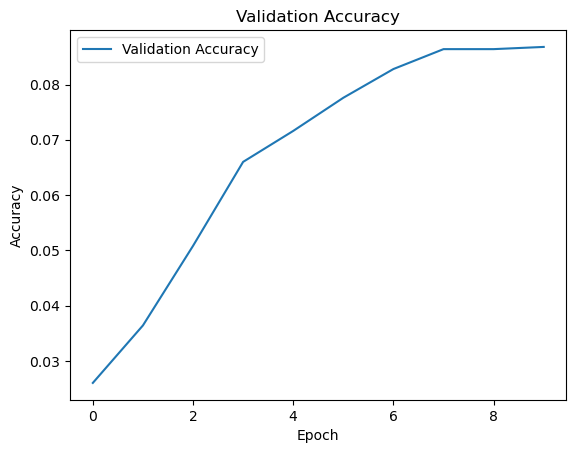

total end_time 1713050009.2701037
Rank 2: Training duration: 2485.43 seconds


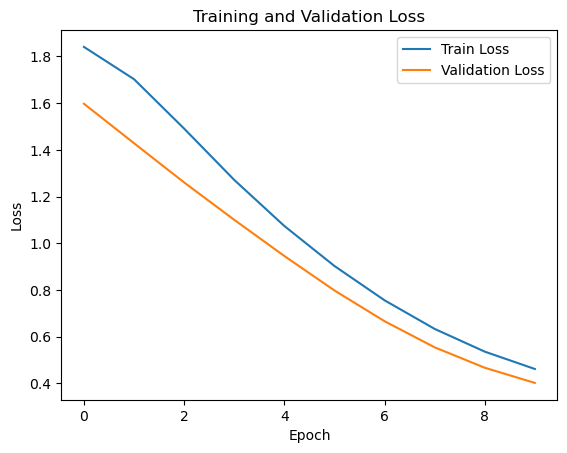

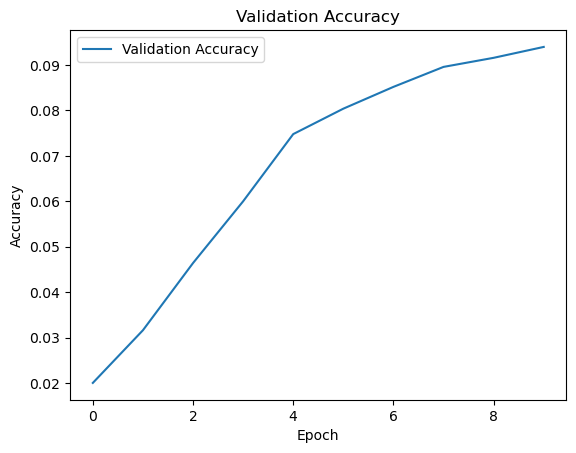

total end_time 1713050009.3344755
Rank 3: Training duration: 2485.36 seconds


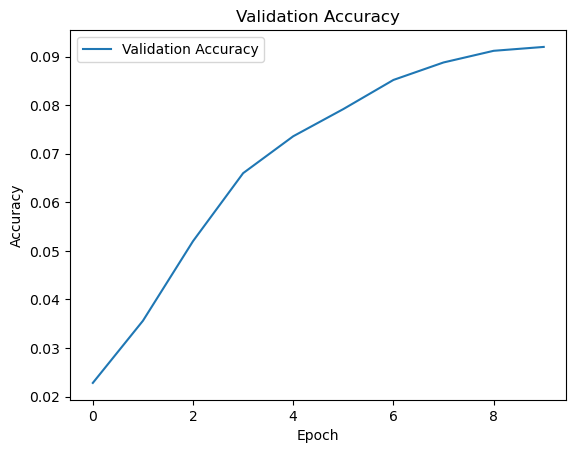

total end_time 1713050009.366736
Rank 0: Training duration: 2485.52 seconds


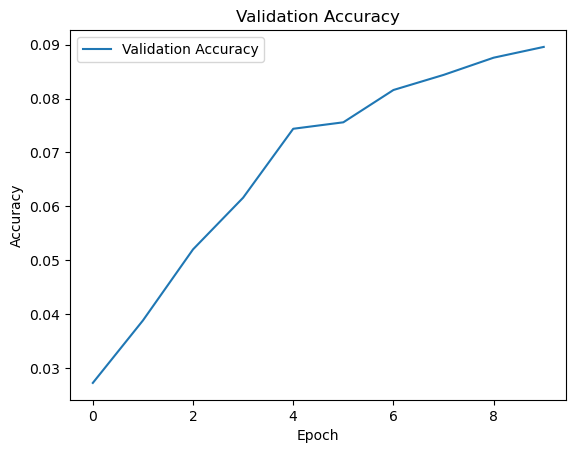

total end_time 1713050009.3735309
Rank 5: Training duration: 2485.15 seconds


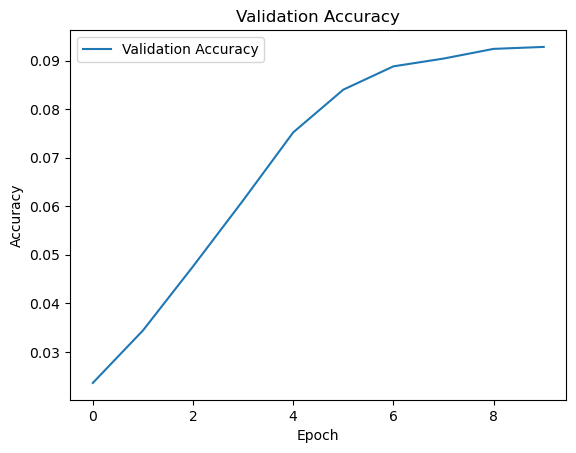

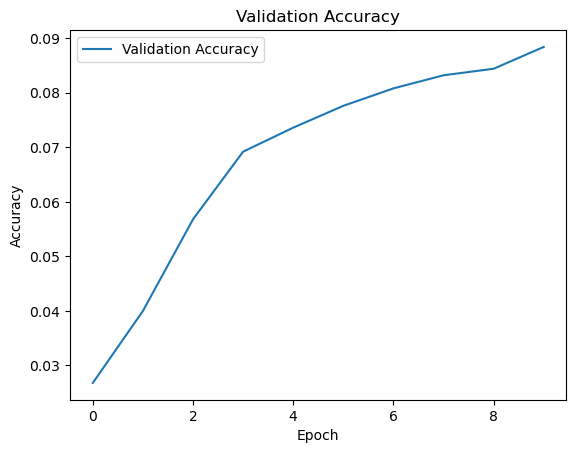

total end_time 1713050009.3784952total end_time
 Rank 9: Training duration: 2485.51 seconds1713050009.379463



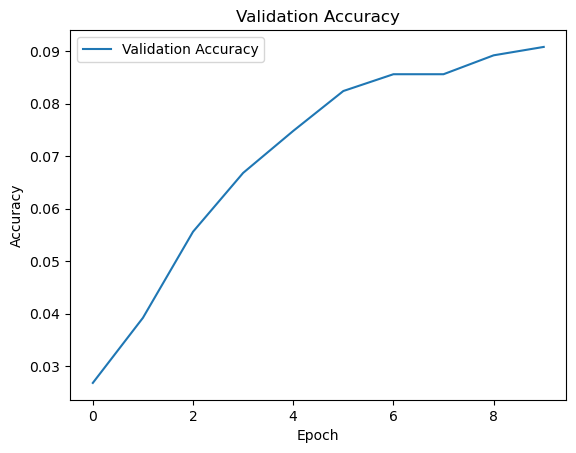

Rank 6: Training duration: 2485.55 seconds
total end_time 1713050009.3826842
Rank 4: Training duration: 2485.53 seconds


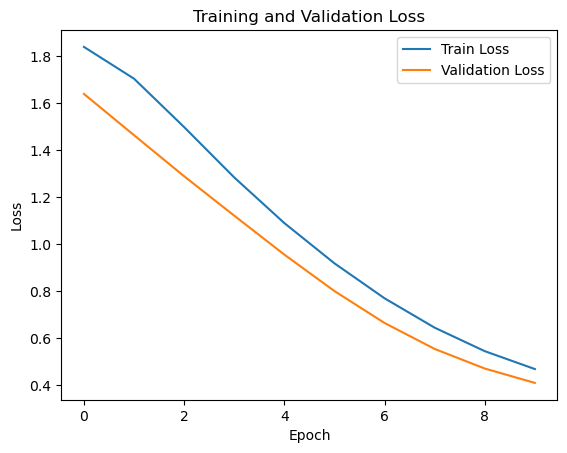

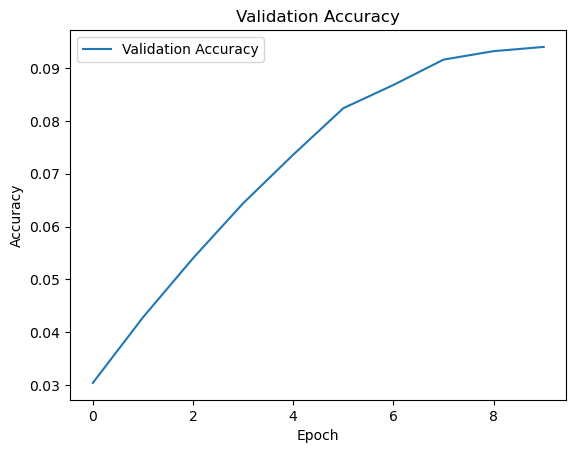

total end_time 1713050009.4276109
Rank 7: Training duration: 2485.09 seconds


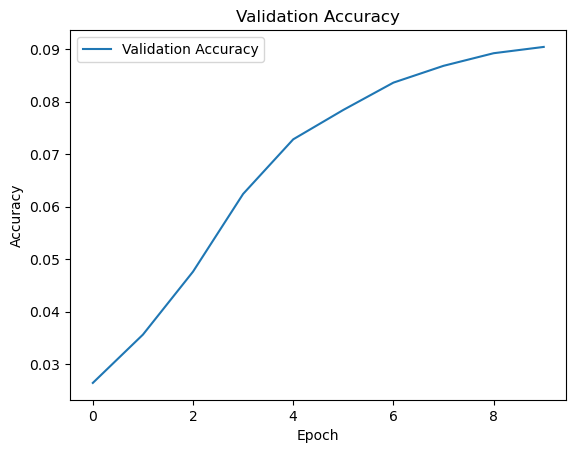

total end_time 1713050009.5459976
Rank 8: Training duration: 2485.67 seconds


In [5]:
if __name__ == '__main__':
    world_size = 10
    batch_size = 1000
    processes = []
    for rank in range(world_size):
        p = mp.Process(target=train, args=(rank, world_size, batch))
        p.start() 
        processes.append(p)
    for p in processes:
        p.join()

In [6]:
num_cpu_cores = torch.get_num_threads()
print("Number of CPU cores:", num_cpu_cores)

Number of CPU cores: 10


Conclusion:

The average duration for each epoch separately:

Epoch 1: 232.53 seconds 
Epoch 2: 231.68 seconds
Epoch 3: 232.53 seconds
Epoch 4: 232.78 seconds
Epoch 5: 233.02 seconds
Epoch 6: 232.57 seconds
Epoch 7: 232.95 seconds
Epoch 8: 232.59 seconds
Epoch 9: 233.25 seconds
Epoch 10: 233.99 seconds

### The average training duration for all 10 epochs is approximately 232.84 seconds.